### Assignment 4: Unsupervised Learning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from joblib import dump, load

Implementation of Bisecting k-Means

In [4]:
def largest_cluster(y_means):
    '''Return the largest cluster from the KMean split'''
    labels = np.bincount(y_means) #counting how many times each label accour
    cluster_max = np.argmax(labels) #Label of the largest cluster
    index = np.where(y_means == cluster_max) #index of max in X
    return index[0]

def bkmeans(XX, k, iter):
    kmeans = KMeans(n_clusters=2, n_init=iter)
    yy = np.zeros(XX[:, 0].shape)
    for i in range(1, k):
        big_cluster = largest_cluster(yy.astype(int))
        temp = big_cluster #index of big cluster points in X
        kmeans.fit(XX[temp].reshape(len(XX[temp]), -1))
        y_means = kmeans.predict(XX[temp].reshape(len(XX[temp]), -1))
        big_cluster = largest_cluster(y_means)# index of big cluster starting from 0
        yy[temp[big_cluster]] = i
    return yy

Implementation of Sammon Mapping

In [11]:
def euclidean_dist(d):
    sum = 0
    for i in range(0, d.shape[0] - 1):
        for j in range(i+1, d.shape[0] - 1):
            sum += distance.euclidean(d[i,:],d[j,:])
    return sum

def E(XX, Y):
    return (1 / euclidean_dist(XX)) * ((euclidean_dist(XX) - euclidean_dist(Y))**2 / euclidean_dist(XX))

def Delta_i(c, Y, XX, i):
    der = 0
    der_2 = 0
    for j in range(0, Y.shape[0]):
        if j != i:
            d_ij = distance.euclidean(Y[i,:], Y[j,:])
            delta_ij = distance.euclidean(XX[i,:], XX[j,:])
            divider_one = (delta_ij * d_ij)
            if divider_one < 1e-9 or d_ij < 1e-9:
                divider_one = 1e-8
                d_ij = 1e-8
            der += ((delta_ij - d_ij) / divider_one) * (Y[i,:] - Y[j,:]) 
            der_2 += (1 / divider_one) * ((delta_ij - d_ij) - (((Y[i,:] - Y[j,:])**2 / d_ij) * (1 + ((delta_ij) - d_ij) / d_ij)))
    der = (-2/c) * der
    der_2 = (-2/c) * der_2
    return der / np.abs(der_2)


def sammon(XX, iter, error_threshold=1e-6, alpha=0.3):
    Y = np.random.normal(size=(len(XX), 2))
    iteration = 0
    c = euclidean_dist(XX)
    new_Y = np.zeros((Y.shape[0], Y.shape[1] ))
    while E(XX, Y) > error_threshold and iteration < iter:
        print(E(XX, Y), 'and iter', iteration)
        for i in range(0, Y.shape[0]):
            delta_i = Delta_i(c, Y, XX, i)
            new_Y[i, :] = Y[i, :] - alpha * delta_i
        iteration += 1
        Y = new_Y
    return Y 

### Visualization of Results
The three dataset I found and used for the comparison of the DR techniques:
<ul>
   <li>
       <b>pc4</b> is one of the NASA Metetric Data Program defect data sets
   </li>
   <li>
       <b>vehicle</b> to classify a given silhouette as one of four types of vehicle, using a set of features extracted
       from the silhouette. The vehicle may be viewed from one of many different angles.
   </li>
   <li>
       <b>breast cancer wisconsin dataset</b> where features are computed from a digitized image of a fine needle aspirate (FNA) of a
       breast mass.
       They describe characteristics of the cell nuclei present in the image. The target feature records the prognosis
       (malignant or benign)
   </li>
<ul>

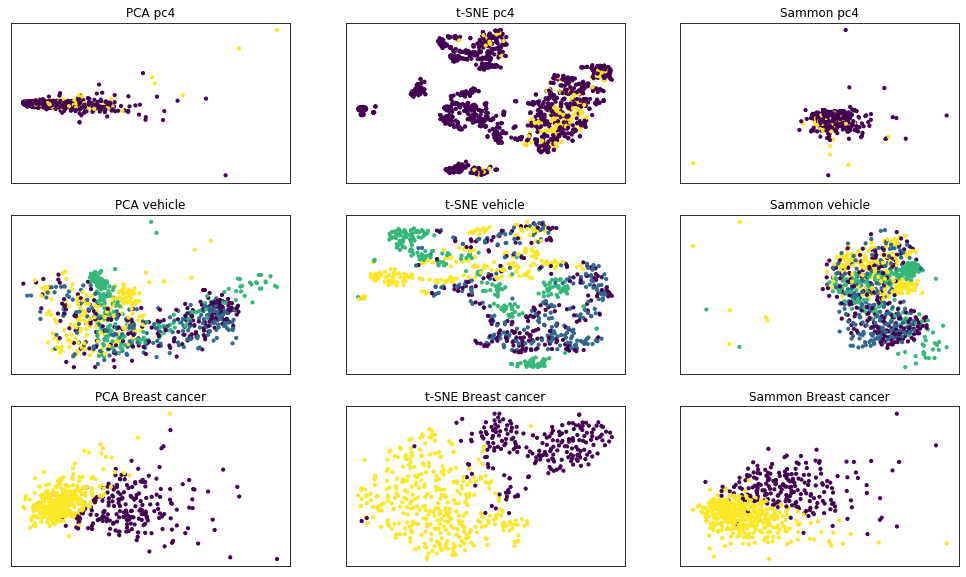

In [22]:
#Use for plotting
DR_list = []
Y_list = []
titels = [
            'PCA pc4', 't-SNE pc4', 'Sammon pc4', 
            'PCA vehicle', 't-SNE vehicle', 'Sammon vehicle',  
            'PCA Breast cancer', 't-SNE Breast cancer', 'Sammon Breast cancer' 
        ]

X_pc4  = np.loadtxt('pc4.csv', delimiter=',', usecols=np.arange(0,37))
y_pc4 = np.loadtxt('pc4.csv', delimiter=',', usecols=37, dtype=str)

#Standardize data
scaler = StandardScaler()
X_pc4 = scaler.fit_transform(X_pc4)

np.place(y_pc4, y_pc4 == 'TRUE', 1)
np.place(y_pc4, y_pc4 == 'FALSE', 0)
y_pc4 = y_pc4.astype('int32')
Y_list.append(y_pc4)

pca = PCA(n_components=2)
Y_pca_pc4 = pca.fit(X_pc4).transform(X_pc4)
DR_list.append(Y_pca_pc4)

Y_tsne_pc4 = TSNE(n_components=2).fit_transform(X_pc4)
DR_list.append(Y_tsne_pc4)

Y_sammon_pc4 = load('Y_sammon_pc4.joblib') #loading the numpy array
#Y_sammon_pc4 = sammon(X_pc4, 50)
#dump(Y_sammon_pc4, 'Y_sammon_pc4.joblib') #saving the numpy array
DR_list.append(Y_sammon_pc4)

# ###Vehical set
X_vehicle  = np.loadtxt('dataset_54_vehicle.csv', delimiter=',', usecols=np.arange(0,17))
y_vehicle = np.loadtxt('dataset_54_vehicle.csv', delimiter=',', usecols=18, dtype=str)

#Standardize data
scaler = StandardScaler()
X_vehicle = scaler.fit_transform(X_vehicle)

np.place(y_vehicle, y_vehicle == 'opel', 0)
np.place(y_vehicle, y_vehicle == 'saab', 1)
np.place(y_vehicle, y_vehicle == 'bus', 2)
np.place(y_vehicle, y_vehicle == 'van', 3)
y_vehicle = y_vehicle.astype('int32')
Y_list.append(y_vehicle)

pca = PCA(n_components=2)
Y_pca_vehicle = pca.fit(X_vehicle).transform(X_vehicle)
DR_list.append(Y_pca_vehicle)

Y_tsne_vehicle = TSNE(n_components=2).fit_transform(X_vehicle)
DR_list.append(Y_tsne_vehicle)

Y_sammon_vehicle = load('Y_sammon_vehicle.joblib') #loading the numpy array
#Y_sammon_vehicle = sammon(X_vehicle, 50) 
#dump(Y_sammon_vehicle, 'Y_sammon_vehicle.joblib') #saving the numpy array
DR_list.append(Y_sammon_vehicle)

# ###Breast cancer dataset
data_brest_cancer = load_breast_cancer()
X_breast_cancer = data_brest_cancer.data
y_breast_cancer = data_brest_cancer.target
Y_list.append(y_breast_cancer)

#Standardize data
scaler = StandardScaler()
X_breast_cancer= scaler.fit_transform(X_breast_cancer)


pca = PCA(n_components=2)
Y_pca_breast_cancer = pca.fit(X_breast_cancer).transform(X_breast_cancer)
DR_list.append(Y_pca_breast_cancer)

Y_tsne_breast_cancer = TSNE(n_components=2).fit_transform(X_breast_cancer)
DR_list.append(Y_tsne_breast_cancer)

Y_sammon_breast_cancer = load('Y_sammon_breast_cancer.joblib')  #loading the numpy array
#Y_sammon_breast_cancer = sammon(X_breast_cancer, 50)
DR_list.append(Y_sammon_breast_cancer)
#dump(Y_sammon_breast_cancer, 'Y_sammon_breast_cancer.joblib')  #saving the numpy array

DR_list.append(Y_sammon_vehicle)

#Plot
plt.figure(figsize=(17,10))
label = -1
for i in range(0, 9):
    if i % 3 == 0:
        label = label+1
    plt.subplot(3,3,i+1).title.set_text(titels[i])
    plt.scatter(DR_list[i][:,0], DR_list[i][:,1], c=Y_list[label], s=10)
    plt.xticks([])
    plt.yticks([])


<b>Q.1</b>
<ul>
    <li><b>pc4</b> t-SNE performed best<br></li>
    <li><b>vehicle</b> t-SNE performed best<br></li>
    <li><b>Breast cancer</b> They all performed well but I would say that PCA is the one with the best results .</li>
</ul>
<b>Q.2</b>
<ul>
    <li>With the DR techniques PCA and Sammon Mapping on the datasets <b>pc4</b> and <b>vehicle</b> the classes 
        are very badly separated, they appear almost as one cluster. <b>t-SNE</b> behaves in a better way and 
        separate the classes better but still have one large cluster with mixed classes.<br>
        All three DR techniques works very well on the Breast cancer set. Here it was easy for all the techniques to 
        separate the classes.
</ul>

### Comparison of Clustering Techniques
I am using the results from Sammon Mapping on the three datasets above.

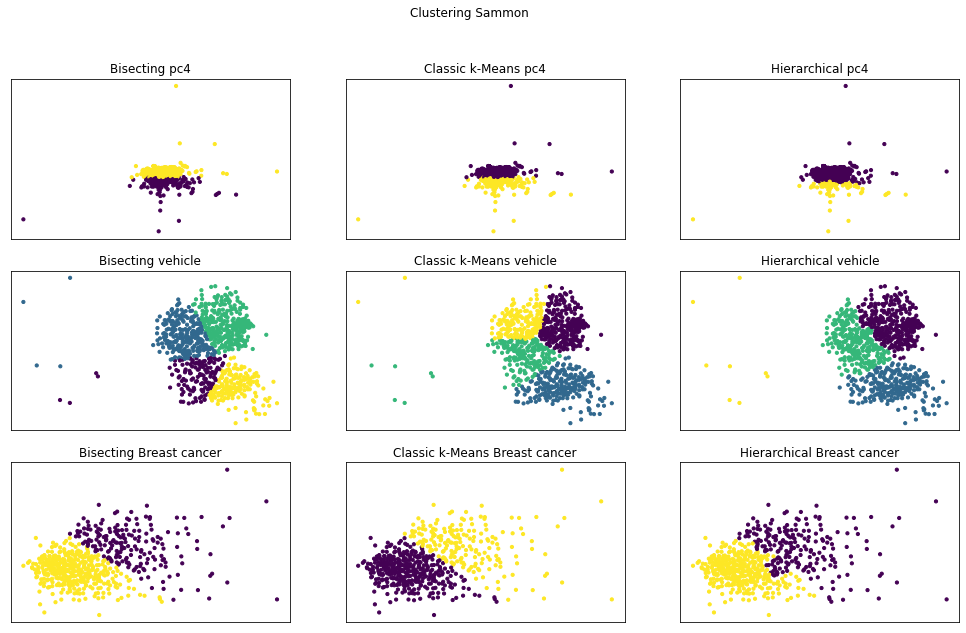

In [19]:
Y_list = []
cluster_list = []
DR_list = [Y_sammon_pc4, Y_sammon_vehicle, Y_sammon_breast_cancer]
titels = [
            'Bisecting pc4', 'Classic k-Means pc4', 'Hierarchical pc4', 
            'Bisecting vehicle', 'Classic k-Means vehicle', 'Hierarchical vehicle',  
            'Bisecting Breast cancer', 'Classic k-Means Breast cancer', 'Hierarchical Breast cancer' 
        ]

#pc4 dataset
Bisecting_clustering_pc4 = bkmeans(Y_sammon_pc4, 2, 20)
kMeans_clustering_pc4 = KMeans(n_clusters=2, n_init=20).fit(Y_sammon_pc4)
kMeans_pc4_labels = kMeans_clustering_pc4.predict(Y_sammon_pc4)
hierarchical_clustering_pc4 = AgglomerativeClustering(n_clusters=2).fit(Y_sammon_pc4)
hirearchical_pc4_labels = hierarchical_clustering_pc4.fit_predict(Y_sammon_pc4)

cluster_list.append(Bisecting_clustering_pc4)
cluster_list.append(kMeans_pc4_labels)
cluster_list.append(hirearchical_pc4_labels)

#vehicle dataset
Bisecting_clustering_vehicle = bkmeans(Y_sammon_vehicle, 4, 20)
kMeans_clustering_vehicle = KMeans(n_clusters=4, n_init=20).fit(Y_sammon_vehicle)
kMeans_vehicle_labels = kMeans_clustering_vehicle.predict(Y_sammon_vehicle)
hierarchical_clustering_vehicle = AgglomerativeClustering(n_clusters=4).fit(Y_sammon_vehicle)
hierarchical_vehicle_labels = hierarchical_clustering_vehicle.fit_predict(Y_sammon_vehicle)

cluster_list.append(Bisecting_clustering_vehicle)
cluster_list.append(kMeans_vehicle_labels)
cluster_list.append(hierarchical_vehicle_labels)

#Breast cancer dataset
Bisecting_clustering_breast_cancer = bkmeans(Y_sammon_breast_cancer, 2, 20)
kMeans_clustering_breast_cancer = KMeans(n_clusters=2, n_init=20).fit(Y_sammon_breast_cancer)
kMeans_breast_cancer_labels = kMeans_clustering_breast_cancer.predict(Y_sammon_breast_cancer)
hierarchical_clustering_breast_cancer = AgglomerativeClustering(n_clusters=2).fit(Y_sammon_breast_cancer)
hierarchical_breast_cancer_labels = hierarchical_clustering_breast_cancer.fit_predict(Y_sammon_breast_cancer)

cluster_list.append(Bisecting_clustering_breast_cancer)
cluster_list.append(kMeans_breast_cancer_labels)
cluster_list.append(hierarchical_breast_cancer_labels)


#Plot
plt.figure(figsize=(17,10)).suptitle('Clustering Sammon')
label = -1
for i in range(0, 9):
    if i % 3 == 0:
        label = label+1
    plt.subplot(3,3,i+1).title.set_text(titels[i])
    plt.scatter(DR_list[label][:,0], DR_list[label][:,1], c=cluster_list[i], s=10)
    plt.xticks([])
    plt.yticks([])
plt.show()

<ul>
    <li><b>pc4</b> Hierarchical performed best<br></li>
    <li><b>vehicle</b> All performed good and the result is very similar<br></li>
    <li><b>Breast cancer</b> All performed good, Hierarchical is not cut as a strait line which makes it more flexible</li>
</ul>
I would say the reson for hierarchical performing best is because it starts from every single poit and check what class the closest point belongs to. This makes it able to grow and form clusters that are more flexible than bisecting and classic k-Means which starts by looking at all the points and then slicing the entire dataset into smaller clusters.